In [1]:
import numpy as np
import pandas as pd
pd.set_option ('display.max_columns', None)
pd.set_option ('display.max_rows', None)
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

###### Neighborhoods of Baku

I collected data about divisions called raions and subdivisions(neighbourhoods) from Wikipedia and used geographical location which was provided there, and missing ones were found using google map. Then created table in Excel which contains the list of division, subdivision and their	 latitude and longitude.

In [2]:
baku_df = pd.read_excel('Baku_coordinates.xlsx', usecols=list(range(0, 7)), header=1)
baku_df.head(10)

,Raions,Subdivisions,Latitude,Longitude
0,Nasimi raion,2nd microdistrict,40.413341,49.816159
1,Nasimi raion,3th microdistrict,40.409066,49.814411
2,Nasimi raion,4th microdistrict,40.415929,49.805075
3,Binagadi raion,6th microdistrict,40.419114,49.818975
4,Binagadi raion,7th microdistrict,40.429367,49.847434
5,Binagadi raion,8th microdistrict,40.421250,49.836913
6,Binagadi raion,9th microdistrict,40.420800,49.797520
7,Nasimi raion,Zorge park,40.390614,49.835017
8,Yasamal raion,Izmir park,40.385238,49.821588
9,Khatai raion,White city,40.382046,49.878552


In [3]:
print ('I will explore information about appartments sale price and venues in  {} in which {} subdivisons'.format(
(baku_df['Raions'].unique()), len(baku_df)))

I will explore information about appartments sale price and venues in  ['Nasimi raion' 'Binagadi raion' 'Yasamal raion' 'Khatai raion'
 'Narimanov raion' 'Sabuncu raion' 'Nizami raion' 'Sabail raion'] in which 28 subdivisons


Using geopy library I will find geographical coordinate of Baku, generate map using folium library and superimpose on it label of neighborhoods.

In [4]:
from geopy.geocoders import Nominatim

address = 'Baku, Azerbaijan'

geolocator = Nominatim(user_agent = "baku_explorer", timeout=None)
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print ('The geographical coordinates of Baku are {},{}'.format(latitude, longitude))

The geographical coordinates of Baku are 40.3754434,49.8326748


In [5]:
import folium 
map_baku = folium.Map(location=[latitude, longitude], zoom_start=12)
for lat, lng, borough, raion in zip(baku_df['Latitude'], baku_df['Longitude'],
                                          baku_df['Subdivisions'], baku_df['Raions']):
    label = '{}, {}'.format(borough, raion)
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius=5,
    popup=label,
    color='red',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_baku)

map_baku

##### Appartment Prices

When somebody plan to invest in apartment, besides apartmenties specification we always should consider location.
Is it near to transport hub? Can we commit conveniently? What is the regular price per sqm in selecter neighborhood?
Let's start our analysis.


I load information from retail property sale site https://bina.az (using requests and BeautifulSoup, run that codes
and prepare excel tabel with data)
about apartments which include price per square meter, location, nearest metro station in selected raions and subdivisions. Let's load this tabel in Pandas dataframe and make some exploratory data analysis.

In [6]:
flats = pd.read_excel('all_flats.xlsx', sheet_name='all', usecols=list(range(1, 7)), header=0 )
flats.head()

,price_AZN per sqm,Unnamed: 2,Unnamed: 3,Unnamed: 4,category
0,1 600,Narimanov raion,NaN,Narimanov metro,new
1,1 580,Binagadi raion,9th microdistrict,Nasimi metro,old
2,1 580,Binagadi raion,9th microdistrict,Nasimi metro,old
3,1 610,Nasimi raion,Nasimi bazar,NaN,old
4,1 610,Nasimi raion,Nasimi bazar,NaN,old


Mainly in Baku appartments divided in two category old buildings which is more than 20 year old, and new modern buildings which were constructed during last 20 years. Let's examine type of column category and convert to categorical value.


In [7]:
flats.dtypes

price_AZN per sqm    object
Unnamed: 2           object
Unnamed: 3           object
Unnamed: 4           object
category             object
dtype: object

In [8]:
#Rename columns
flats.columns = ['price', 'raion', 'district', 'nearest_metro', 'category']

In [9]:
flats.head(10)

,price,raion,district,nearest_metro,category
0,1 600,Narimanov raion,NaN,Narimanov metro,new
1,1 580,Binagadi raion,9th microdistrict,Nasimi metro,old
2,1 580,Binagadi raion,9th microdistrict,Nasimi metro,old
3,1 610,Nasimi raion,Nasimi bazar,NaN,old
4,1 610,Nasimi raion,Nasimi bazar,NaN,old
5,1 350,Nizami raion,8th kilometer,Neftchilar metro,new
6,1 070,Yasamal raion,Yeni Yasamal,NaN,old
7,1 070,Yasamal raion,Yeni Yasamal,NaN,old
8,1 690,Nasimi raion,NaN,28 may metro,old
9,1 690,Nasimi raion,NaN,28 may metro,old


For exploratory analysis let's change type of category column to categorical, and price column to numerical

In [10]:
flats['category']=flats['category'].astype('category')

In [11]:
flats['price'] = flats['price'].apply(lambda x: (str(x)).replace(' ', ''))


In [12]:
flats['price']=flats['price'].astype('float')

In [13]:
# First have a look mean price for square meter in different districts
flats.groupby(['raion']).mean()

,price
raion,
Binagadi raion,1466.628571
Khatai raion,1713.715686
Narimanov raion,2011.757895
Nasimi raion,1735.909605
Nizami raion,1272.045333
Sabail raion,2089.423077
Sabuncu raion,1207.285714
Yasamal raion,1749.547945


In [14]:
#Now I will create boxplot using seaborn to see distribution of prices
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(22,10))
sns.set_context("poster", rc={"font.size":28,"axes.titlesize":15,"axes.labelsize":18}) 
fig = sns.boxplot(x=flats['raion'], y=flats['price'], hue=flats['category']).set_title
plt.title('Distribution of appartments prices per sqm in different raion in Baku, Azerbijan', fontsize=25)


plt.xlabel("District")
plt.ylabel("Price for sqm(AZN)")
plt.show()

<Figure size 2200x1000 with 1 Axes>

#Using boxplot visualization , help us to check is it any outlier in our data set. For our dataset we see max outliers and min outliers, let's check exact value for 5 smallest and 5 largest

In [15]:
flats['price'].nsmallest(5)

617      1.36
127     10.00
128     10.00
120    677.00
507    696.00
Name: price, dtype: float64

In [16]:
flats['price'].nlargest(5)

317    6250.0
318    6250.0
361    6250.0
362    6250.0
138    5650.0
Name: price, dtype: float64

During data collection some incorrect data may be indicated, we can apply one of two methods for it:
*replace this data with mean value of columns
*drop row
In our particular case price for some appartments is higher than usual, but minimum value price 1.36 , which is looking unreal.

Since price of apartment is main variable which we use for our analysis, we will drop row with minimum value of outlier.

In [17]:
#Drop row with 3 smallest values
flats.drop(index=[617, 127, 128], inplace=True)

In [18]:
flats.describe()

,price
count,749.000000
mean,1754.643525
std,683.682237
min,677.000000
25%,1330.000000
50%,1650.000000
75%,1960.000000
max,6250.000000


We will merge dataframes, containing information about coordinates of neighrborhoods and prices for apartments

In [19]:
df = flats.groupby(['district']).mean()
baku_price = pd.merge(baku_df, df, left_on=['Subdivisions'], right_on=['district'])
baku_price.head(10)

,Raions,Subdivisions,Latitude,Longitude,price
0,Nasimi raion,2nd microdistrict,40.413341,49.816159,1060.000000
1,Nasimi raion,3th microdistrict,40.409066,49.814411,1353.636364
2,Nasimi raion,4th microdistrict,40.415929,49.805075,1461.333333
3,Binagadi raion,6th microdistrict,40.419114,49.818975,1344.285714
4,Binagadi raion,7th microdistrict,40.429367,49.847434,1499.090909
5,Binagadi raion,8th microdistrict,40.421250,49.836913,1640.454545
6,Binagadi raion,9th microdistrict,40.420800,49.797520,1401.176471
7,Nasimi raion,Zorge park,40.390614,49.835017,1862.500000
8,Yasamal raion,Izmir park,40.385238,49.821588,2418.000000
9,Yasamal raion,Beshmartaba,40.386244,49.833450,2420.000000


In [20]:
import folium 
map_baku = folium.Map(location=[latitude, longitude], zoom_start=12)
for lat, lng, district, price in zip(baku_price['Latitude'], baku_price['Longitude'],
                                          baku_price['Subdivisions'], baku_price['price']):
    label = '{}, {}'.format(district, price)
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_baku)

map_baku

One of the main criteria for apartment’s location, is it near to transportation hub? The transportation hubs i.e. bus stations and taxi stands in Baku city are mainly located near metro stations, therefore we select apartments near metro stations and do exploratory analysis on average price per sqm near each metro station.

In [21]:
flats_metro=flats[flats['nearest_metro'].notnull()]

In [22]:
flats_metro.head(10)

,price,raion,district,nearest_metro,category
0,1600.0,Narimanov raion,NaN,Narimanov metro,new
1,1580.0,Binagadi raion,9th microdistrict,Nasimi metro,old
2,1580.0,Binagadi raion,9th microdistrict,Nasimi metro,old
5,1350.0,Nizami raion,8th kilometer,Neftchilar metro,new
8,1690.0,Nasimi raion,NaN,28 may metro,old
9,1690.0,Nasimi raion,NaN,28 may metro,old
11,1040.0,Nasimi raion,4th microdistrict,Memar Ajami metro,old
12,1040.0,Nasimi raion,4th microdistrict,Memar Ajami metro,old
13,1220.0,Nasimi raion,4th microdistrict,Memar Ajami metro,old
14,1220.0,Nasimi raion,4th microdistrict,Memar Ajami metro,old


In [23]:
flats_metro['nearest_metro'].unique()

array(['Narimanov metro', 'Nasimi metro', 'Neftchilar metro',
       '28 may metro', 'Memar Ajami metro', 'Inshaatchilar metro',
       'Azadlig metro', 'Hazi Aslanov metro', 'Elmlar Akademiyasi metro',
       'Khatai metro', 'Akhmedli metro', 'Gara Garayev metro',
       '20 yanvar metro', 'Old City metro', 'Ganjlik metro',
       'Sahil metro', 'Nizami metro', 'Khalglar Dostlughu metro',
       'Ulduz metro'], dtype=object)

In [24]:
metro_mean = flats_metro.groupby(['nearest_metro']).mean()

In [25]:
metro_mean.head(19)

,price
nearest_metro,
20 yanvar metro,1658.800000
28 may metro,2029.761905
Akhmedli metro,1309.230769
Azadlig metro,1466.666667
Elmlar Akademiyasi metro,2167.272727
Ganjlik metro,2568.400000
Gara Garayev metro,1286.250000
Hazi Aslanov metro,1249.666667
Inshaatchilar metro,1456.696970


In [26]:
metro_geo = pd.read_excel('Baku_coordinates.xlsx', sheet_name='metro', usecols=list(range(1, 4)), skiprows=range(0,2))
metro_geo.columns=["metro", "latitude", "longitude"]
metro_geo.head()

,metro,latitude,longitude
0,28 may metro,40.380028,49.850841
1,Ganjlik metro,40.400486,49.853731
2,Memar Ajami metro,40.400479,49.869052
3,Azadlig metro,40.426050,49.838662
4,Darnagul metro,40.408126,49.856092


In [27]:
metro = pd.merge(metro_geo, metro_mean, left_on="metro", right_on="nearest_metro")
metro.head()

,metro,latitude,longitude,price
0,28 may metro,40.380028,49.850841,2029.761905
1,Ganjlik metro,40.400486,49.853731,2568.400000
2,Memar Ajami metro,40.400479,49.869052,1354.800000
3,Elmlar Akademiyasi metro,40.380148,49.841501,2167.272727
4,Nizami metro,40.379191,49.832005,1928.421053


In [29]:
import folium 
metro_baku = folium.Map(location=[latitude, longitude], zoom_start=12)
for lat, lng, price, metro in zip(metro['latitude'], metro['longitude'],
                                          metro['price'], metro['metro']):
    label = '{}, {}'.format(price, metro)
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius=5,    popup=label,
    color='green',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(metro_baku)

metro_baku

In [30]:
CLIENT_ID = "0HRDWP1IKCCSKALJDWFCCSFBG2214SVN4N5TL53O0JLYHGE3"
CLIENT_SECRET = 'OR2R45JED2I3AMXBGIBIORVPNRNHPMKHASH34GEAWZC20KSA'
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 0HRDWP1IKCCSKALJDWFCCSFBG2214SVN4N5TL53O0JLYHGE3
CLIENT_SECRET:OR2R45JED2I3AMXBGIBIORVPNRNHPMKHASH34GEAWZC20KSA


In [31]:
def getNearbyVenues(names, latitudes, longitudes, radius=900):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [32]:
baku_venues = getNearbyVenues(names=baku_df['Subdivisions'],
                                   latitudes=baku_df['Latitude'],
                                   longitudes=baku_df['Longitude']
                                  )

2nd microdistrict
3th microdistrict
4th microdistrict
6th microdistrict
7th microdistrict
8th microdistrict
9th microdistrict
Zorge park
Izmir park
White city
Beshmartaba
Ayna Sultanova
East Bazaar
Medical University
Bakixanov district
8th kilometer
TQDK
Samed Vurgun park
Badamdar
Zabitlar park
Bayil district
Yeni Yasamal
Nasimi bazar
Gunashli
Akhmedli
Bilajari
Javanshir Bridge
State Statistics Committee


In [33]:
baku_venues.shape

(1345, 7)

In [34]:
baku_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,2nd microdistrict,40.413341,49.816159,Papa John's,40.409949,49.814276,Italian Restaurant
1,2nd microdistrict,40.413341,49.816159,Edem Fitness & Spa,40.407561,49.811484,Gym Pool
2,2nd microdistrict,40.413341,49.816159,AS Lounge,40.411878,49.821344,Karaoke Bar
3,2nd microdistrict,40.413341,49.816159,McDonald's,40.410264,49.813984,Fast Food Restaurant
4,2nd microdistrict,40.413341,49.816159,Ideal Parfumery & Cosmetics,40.411005,49.817553,Cosmetics Shop
5,2nd microdistrict,40.413341,49.816159,Grace Beauty Complex,40.410646,49.815447,Gym / Fitness Center
6,2nd microdistrict,40.413341,49.816159,Favorit Market,40.418813,49.810967,Supermarket
7,2nd microdistrict,40.413341,49.816159,Saraclı Gürcü Mətbəxi,40.419235,49.818224,Restaurant
8,2nd microdistrict,40.413341,49.816159,New Life,40.419921,49.817416,Café
9,2nd microdistrict,40.413341,49.816159,Spar Supermarket,40.406810,49.812777,Market


In [35]:
baku_venues['Venue'].drop_duplicates(inplace=True)

In [36]:
baku_venues.shape

(1345, 7)

In [37]:
baku_venues.groupby('Venue Category')['Neighborhood'].count()

Venue Category
ATM                                           1
American Restaurant                           1
Arcade                                        2
Art Gallery                                   2
Art Museum                                    1
Arts & Crafts Store                           3
Asian Restaurant                             15
Athletics & Sports                           14
Auto Workshop                                 1
BBQ Joint                                     3
Baby Store                                    2
Bakery                                       23
Bar                                           7
Bed & Breakfast                               1
Beer Bar                                      1
Big Box Store                                 6
Bistro                                        1
Board Shop                                    2
Boarding House                                1
Bookstore                                     8
Border Crossing          

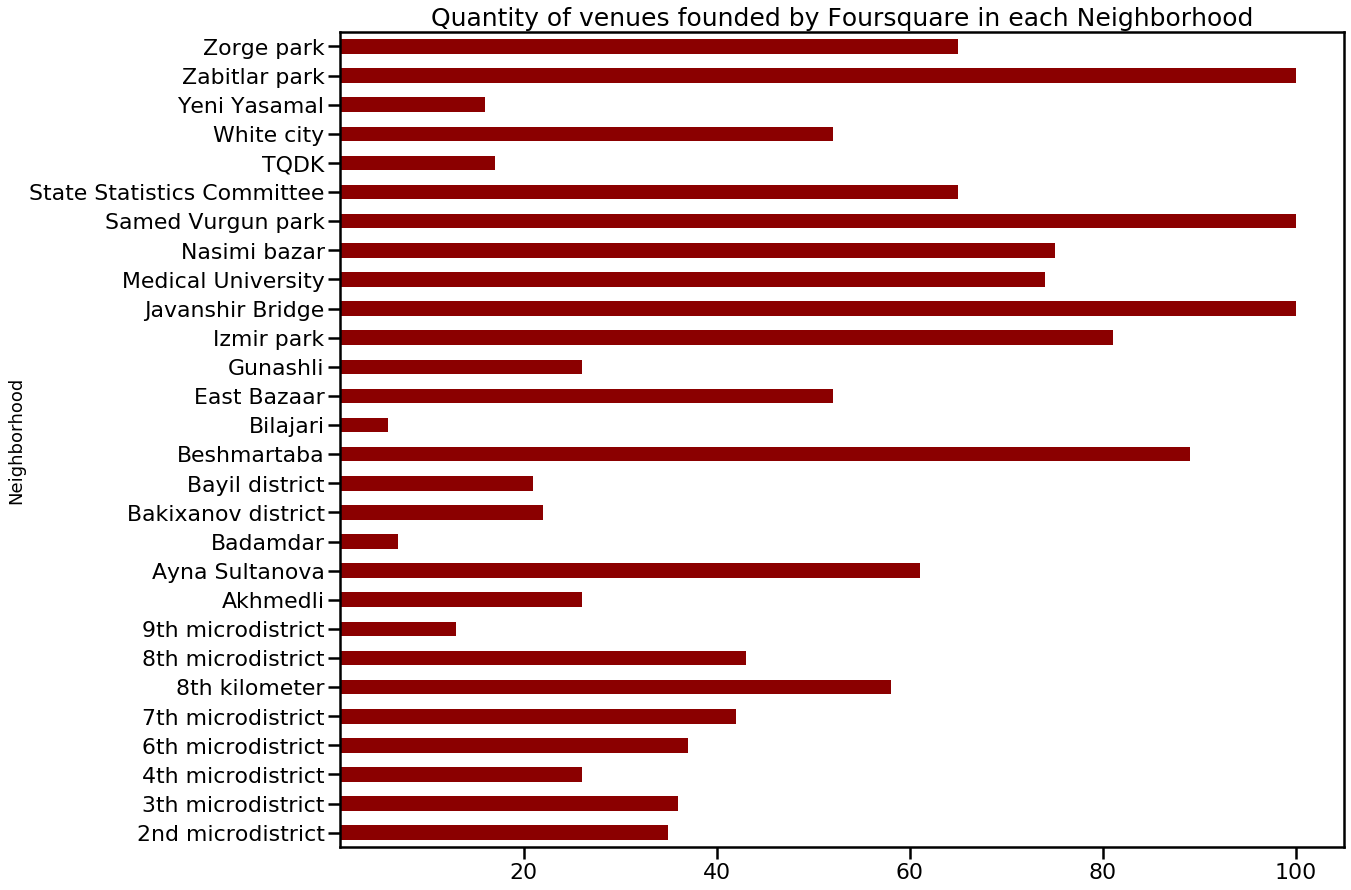

In [38]:
#Let's create barchart showing number of venues in each neighborhood

import matplotlib.pyplot as plt
df = baku_venues.groupby('Neighborhood')['Venue Category'].count()
plt.figure(figsize=(18, 15))
ax = df.plot.barh(color='darkred')
ax.set_xlim(1, 105)
plt.title("Quantity of venues founded by Foursquare in each Neighborhood", fontsize=25)
plt.show()

###### For analizing each neighborhood we use get_dummies and turn Venue Category columns to separate column for each category containing 0 or 1 value and 

In [39]:
baku_onehot = pd.get_dummies(baku_venues[['Venue Category']], prefix='', prefix_sep='')
baku_onehot.shape

(1345, 160)

In [40]:
#add neighborhood columns back to new dataframe
baku_onehot['Neighborhood'] = baku_venues['Neighborhood'] 

# move neighborhood column to the first column

fixed_columns = [baku_onehot.columns[-1]] + list(baku_onehot.columns[:-1])
baku_onehot = baku_onehot[fixed_columns]

baku_onehot.columns[0:10]

Index(['Zoo', 'ATM', 'American Restaurant', 'Arcade', 'Art Gallery',
       'Art Museum', 'Arts & Crafts Store', 'Asian Restaurant',
       'Athletics & Sports', 'Auto Workshop'],
      dtype='object')

###### group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [41]:
baku_grouped = baku_onehot.groupby('Neighborhood').mean().reset_index()
baku_grouped

,Neighborhood,Zoo,ATM,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bakery,Bar,Bed & Breakfast,Beer Bar,Big Box Store,Bistro,Board Shop,Boarding House,Bookstore,Border Crossing,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Bus Station,Café,Caucasian Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Department Store,Dessert Shop,Diner,Doner Restaurant,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gastropub,General Entertainment,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hookah Bar,Hot Spring,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Karaoke Bar,Kebab Restaurant,Kids Store,Lake,Leather Goods Store,Lingerie Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Motel,Movie Theater,Multiplex,Music Venue,Nightclub,Office,Optical Shop,Other Great Outdoors,Outdoor Supply Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Print Shop,Pub,Racetrack,Recording Studio,Residential Building (Apartment / Condo),Restaurant,Russian Restaurant,Salon / Barbershop,Sculpture Garden,Seafood Restaurant,Shopping Mall,Snack Place,Soccer Field,Soccer Stadium,Social Club,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Summer Camp,Supermarket,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Track Stadium,Trail,Train Station,Turkish Restaurant,Ukrainian Restaurant,Wings Joint,Women's Store
0,2nd microdistrict,0.000000,0.00000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.028571,0.000000,0.000000,0.000000,0.028571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.057143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.028571,0.000000,0.028571,0.028571,0.028571,0.00,0.000000,0.000000,0.028571,0.000000,0.00,0.000000,0.000000,0.085714,0.000000,0.000000,0.000000,0.00,0.028571,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028571,0.028571,0.000000,0.000000,0.000000,0.000000,0.00000,0.057143,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.028571,0.000000,0.00,0.000000,0.000000,0.028571,0.000000,0.000000,0.000000,0.000000,0.00,0.057143,0.028571,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.028571,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.200000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028571,0.000000,0.000000,0.000000,0.00,0.000000,0.028571,0.000000,0.028571,0.000000,0.028571,0.028571,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3th microdistrict,0.000000,0.00000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.055556,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.00,0.000000,0.000000,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000,0.027778,0.000000,0.000000,0.027778,0.000000,0.00,0.027778,0.027778

In [42]:
num_top_venues = 5

for hood in baku_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = baku_grouped[baku_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----2nd microdistrict----
                  venue  freq
0            Restaurant  0.20
1  Fast Food Restaurant  0.09
2                Lounge  0.06
3            Hookah Bar  0.06
4                  Café  0.06


----3th microdistrict----
                   venue  freq
0             Restaurant  0.14
1   Fast Food Restaurant  0.08
2     Athletics & Sports  0.06
3               Tea Room  0.06
4  College Arts Building  0.03


----4th microdistrict----
         venue  freq
0   Restaurant  0.12
1  Bus Station  0.12
2  Supermarket  0.08
3   Steakhouse  0.08
4   Hookah Bar  0.08


----6th microdistrict----
                       venue  freq
0                 Restaurant  0.22
1                       Café  0.11
2                 Hookah Bar  0.08
3  Middle Eastern Restaurant  0.05
4                      Diner  0.05


----7th microdistrict----
           venue  freq
0     Restaurant  0.21
1           Café  0.14
2            Gym  0.05
3           Park  0.05
4  Metro Station  0.05


----8th kilometer---

In [43]:
# function to sort the venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

###### create the new dataframe and display the top 10 venues for each neighborhood

In [44]:
num_top_venues = 10
import numpy as np
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = baku_grouped['Neighborhood']

for ind in np.arange(baku_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(baku_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(15)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2nd microdistrict,Restaurant,Fast Food Restaurant,Lounge,Hookah Bar,Café,Park,Supermarket,Eastern European Restaurant,Soccer Stadium,Karaoke Bar
1,3th microdistrict,Restaurant,Fast Food Restaurant,Tea Room,Athletics & Sports,Breakfast Spot,Cosmetics Shop,Bookstore,Lounge,Clothing Store,Sports Club
2,4th microdistrict,Bus Station,Restaurant,Supermarket,Hookah Bar,Steakhouse,Clothing Store,Movie Theater,Eastern European Restaurant,Metro Station,Shopping Mall
3,6th microdistrict,Restaurant,Café,Hookah Bar,Diner,Lounge,Middle Eastern Restaurant,Park,Cupcake Shop,Pub,Comfort Food Restaurant
4,7th microdistrict,Restaurant,Café,Market,Metro Station,Gym,Park,Dumpling Restaurant,Eastern European Restaurant,Residential Building (Apartment / Condo),Soccer Stadium
5,8th kilometer,Restaurant,Tea Room,Café,Hotel,Pub,Park,Breakfast Spot,Market,Eastern European Restaurant,Women's Store
6,8th microdistrict,Restaurant,Park,Café,Lounge,Eastern European Restaurant,Metro Station,Halal Restaurant,Market,Electronics Store,Snack Place
7,9th microdistrict,Bus Station,Hotel,Asian Restaurant,Shopping Mall,Board Shop,Restaurant,Jewelry Store,Grocery Store,Clothing Store,Comfort Food Restaurant
8,Akhmedli,Restaurant,Bakery,Park,Comfort Food Restaurant,Big Box Store,Café,Fast Food Restaurant,Snack Place,Metro Station,Bookstore
9,Ayna Sultanova,Restaurant,Hotel,Gym,Clothing Store,Middle Eastern Restaurant,Eastern European Restaurant,Pizza Place,Market,Lounge,Park


##### Cluster neigborhoods using K-means algorithm and find optimal number of clusters (K value) using elbow method

In [45]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer
X = baku_grouped.drop('Neighborhood', 1)

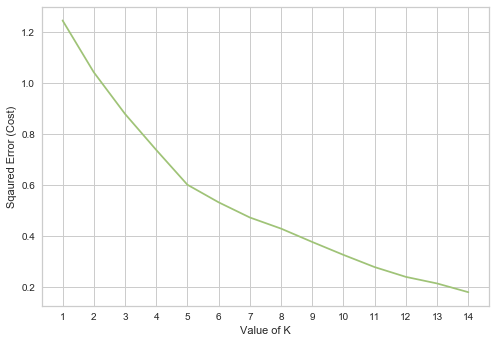

In [46]:

cost =[] 
for i in range(1, 15): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(X) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 15), cost, color ='g') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.xticks (range(1, 15))
plt.show() # clear the plot 
  
#  There is not actual elbow, but we wil choose number of K for 6 as optimal where squared error is around 0.6 


In [47]:
kclusters = 6
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)

In [48]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)



In [49]:
baku_merged = baku_price

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
baku_merged = baku_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Subdivisions')

baku_merged.head()

,Raions,Subdivisions,Latitude,Longitude,price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Nasimi raion,2nd microdistrict,40.413341,49.816159,1060.000000,1,Restaurant,Fast Food Restaurant,Lounge,Hookah Bar,Café,Park,Supermarket,Eastern European Restaurant,Soccer Stadium,Karaoke Bar
1,Nasimi raion,3th microdistrict,40.409066,49.814411,1353.636364,0,Restaurant,Fast Food Restaurant,Tea Room,Athletics & Sports,Breakfast Spot,Cosmetics Shop,Bookstore,Lounge,Clothing Store,Sports Club
2,Nasimi raion,4th microdistrict,40.415929,49.805075,1461.333333,3,Bus Station,Restaurant,Supermarket,Hookah Bar,Steakhouse,Clothing Store,Movie Theater,Eastern European Restaurant,Metro Station,Shopping Mall
3,Binagadi raion,6th microdistrict,40.419114,49.818975,1344.285714,1,Restaurant,Café,Hookah Bar,Diner,Lounge,Middle Eastern Restaurant,Park,Cupcake Shop,Pub,Comfort Food Restaurant
4,Binagadi raion,7th microdistrict,40.429367,49.847434,1499.090909,1,Restaurant,Café,Market,Metro Station,Gym,Park,Dumpling Restaurant,Eastern European Restaurant,Residential Building (Apartment / Condo),Soccer Stadium


In [50]:
baku_merged['Subdivisions']

0              2nd microdistrict
1              3th microdistrict
2              4th microdistrict
3              6th microdistrict
4              7th microdistrict
5              8th microdistrict
6              9th microdistrict
7                     Zorge park
8                     Izmir park
9                    Beshmartaba
10                Ayna Sultanova
11            Medical University
12            Bakixanov district
13                 8th kilometer
14                          TQDK
15             Samed Vurgun park
16                      Badamdar
17                 Zabitlar park
18                Bayil district
19                  Yeni Yasamal
20                  Nasimi bazar
21                      Gunashli
22                      Akhmedli
23                      Bilajari
24              Javanshir Bridge
25    State Statistics Committee
Name: Subdivisions, dtype: object

In [51]:
# add clusters to Baku map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)
import matplotlib.cm as cm
import matplotlib.colors as colors
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, price in zip(baku_merged['Latitude'], baku_merged['Longitude'], baku_merged['Subdivisions'], baku_merged['Cluster Labels'], baku_merged['price']):
    label = folium.Popup(str(poi)  + ' Avg. Price: ' + str(int(price)) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='darkred',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       

In [52]:
map_clusters

In [56]:
baku_merged.loc[baku_merged['Cluster Labels'] == 0, baku_merged.columns[[1] + list(range(5, baku_merged.shape[1]))]]

,Subdivisions,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,3th microdistrict,0,Restaurant,Fast Food Restaurant,Tea Room,Athletics & Sports,Breakfast Spot,Cosmetics Shop,Bookstore,Lounge,Clothing Store,Sports Club
7,Zorge park,0,Café,Restaurant,Fast Food Restaurant,Turkish Restaurant,Park,Hookah Bar,Spa,Dessert Shop,Coffee Shop,Diner
8,Izmir park,0,Restaurant,Café,Hotel,Gym / Fitness Center,Lounge,Spa,Nightclub,Tea Room,Coffee Shop,Pizza Place
9,Beshmartaba,0,Restaurant,Café,Coffee Shop,Karaoke Bar,Hotel,Fast Food Restaurant,Park,Eastern European Restaurant,Spa,Lounge
10,Ayna Sultanova,0,Restaurant,Hotel,Gym,Clothing Store,Middle Eastern Restaurant,Eastern European Restaurant,Pizza Place,Market,Lounge,Park
11,Medical University,0,Café,Restaurant,Turkish Restaurant,Nightclub,Lounge,Hookah Bar,Hotel,Supermarket,Pet Store,Electronics Store
15,Samed Vurgun park,0,Hotel,Coffee Shop,Café,Clothing Store,Restaurant,Park,Lounge,Italian Restaurant,Bakery,Steakhouse
17,Zabitlar park,0,Coffee Shop,Restaurant,Hotel,Clothing Store,Café,Park,Steakhouse,Gym / Fitness Center,Lounge,Plaza
19,Yeni Yasamal,0,Restaurant,Diner,Supermarket,Spa,Theme Park,Middle Eastern Restaurant,Sports Bar,Kebab Restaurant,Tea Room,Coffee Shop
20,Nasimi bazar,0,Café,Restaurant,Turkish Restaurant,Fast Food Restaurant,Hookah Bar,Park,Bakery,Supermarket,Lounge,Health & Beauty Service


In [57]:
baku_merged.loc[baku_merged['Cluster Labels'] == 1, baku_merged.columns[[1] + list(range(5, baku_merged.shape[1]))]]

,Subdivisions,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2nd microdistrict,1,Restaurant,Fast Food Restaurant,Lounge,Hookah Bar,Café,Park,Supermarket,Eastern European Restaurant,Soccer Stadium,Karaoke Bar
3,6th microdistrict,1,Restaurant,Café,Hookah Bar,Diner,Lounge,Middle Eastern Restaurant,Park,Cupcake Shop,Pub,Comfort Food Restaurant
4,7th microdistrict,1,Restaurant,Café,Market,Metro Station,Gym,Park,Dumpling Restaurant,Eastern European Restaurant,Residential Building (Apartment / Condo),Soccer Stadium
5,8th microdistrict,1,Restaurant,Park,Café,Lounge,Eastern European Restaurant,Metro Station,Halal Restaurant,Market,Electronics Store,Snack Place
12,Bakixanov district,1,Restaurant,Café,Tea Room,Metro Station,Hotel,Train Station,Department Store,Optical Shop,Clothing Store,Movie Theater


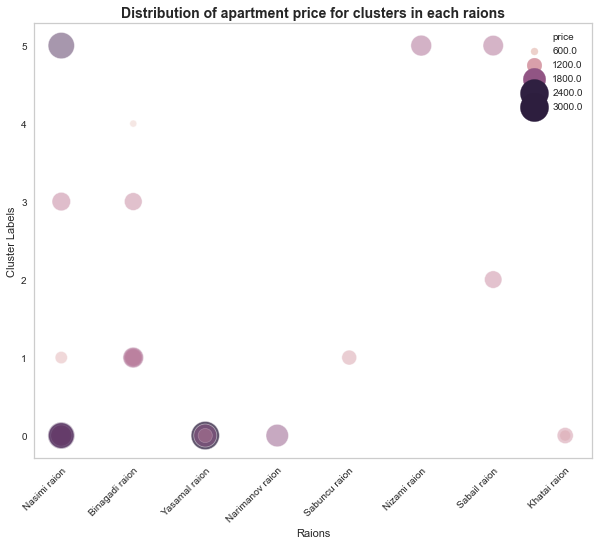

In [55]:
## Plotting an histogram with the neighborhoods sorted alphabetically. 
plt.figure(figsize=(10,8))
x = baku_merged['Raions']
y = baku_merged['Cluster Labels']
s = baku_merged['price']
ax = sns.scatterplot(x, y, size =s, hue=s, sizes=(50, 800), alpha=0.5)

plt.title('Distribution of apartment price for clusters in each raions', fontsize=14, fontweight='bold')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.grid(False)
plt.legend()
plt.show()

Thank you 
This notebook was created by Rahila Imanzada for IBM Applied Data Science Capstone Project